<a href="https://colab.research.google.com/github/claudiohfg/notebooks/blob/main/Heart_Disease_Data_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#990000">Heart Disease Data Set</font>

## Business understanding

The objective of this study is to produce a model that helps predict heart diseases based on available data, collected from:
1. Cleveland Clinic Foundation (cleveland.data)
2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
4. University Hospital, Zurich, Switzerland (switzerland.data)

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1, 2, 3, 4) from absence (value 0).

**We will use all of these four datasets and try to distinguish presence from absence of heart disease.**

## <font color="#0544fe">Data understanding</font>

### <font color="#189ab4">Libs</font>

We will use the following libraries along this study.

In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from tqdm import tqdm

### <font color="#189ab4">Utils</font>

These utility functions will help us analyse and model data.

In [2]:
def exec_cmd(cmd: str, just_print=True) -> str:
    '''Execute shell command cmd and returns the result'''
    result = os.popen('cat heart-disease.names').read()
    if just_print:
        print(result)
    else:
        return result

In [3]:
def abs_scaler(ds: pd.DataFrame) -> pd.DataFrame:
    """
    Receive a dataframe, apply MaxAbsScaler transformation
    and return the dataset with the same columns and data
    in the same scale for analysis purposes.

    >>> abs_scaler(pd.DataFrame(
        (np.random.rand(10, 3) * 100),
        columns=['A', 'B', 'C']
    )).max().values == np.array([1., 1., 1.])
    np

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    
    Returns
    -------
    ds : pd.DataFrame
        Scaled dataset.
    """
    
    arr = MaxAbsScaler().fit_transform(ds.values)
    return pd.DataFrame(arr, columns=ds.columns)

In [4]:
def label_feature(
    ds: pd.DataFrame,
    feature: str,
    n_parts: int,
    qcut=True) -> pd.DataFrame:
    """
    Generates label feature either distributing
    data equally or normally.

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    
    Returns
    -------
    ds : pd.DataFrame
        Scaled dataset.
    """
    
    feat_sparse = f"{feature}_label"
    feat_label = f"{feature}_lbl"

    if qcut:
        ds[feat_sparse] = pd.qcut(ds[feature], n_parts, duplicates='drop')
    else:
        ds[feat_sparse] = pd.cut(ds[feature], n_parts, duplicates='drop')

    ds[feat_label] = LabelEncoder().fit_transform(ds[feat_sparse])
    ds.drop(labels=[feat_sparse], axis=1, inplace=True)

    return ds

In [5]:
def quantify_features(
    ds: pd.DataFrame,
    verbose=True,
    target='target',
    correlation_threshold=0.9
) -> pd.DataFrame:
    """
    Automatically selections features to quantify,
    analyses how they should be quantified, label encode
    the features and select the ones that should remain
    considering the correlation to the original features.

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    verbose : Boolean
        If there should be an output or not.
    correlation_threshold : float
        The limit above which the feature should be dropped.
    
    Returns
    -------
    ds : pd.DataFrame
        Dataset with new quantified features.
    """
    features_to_quantize = []

    for feature in ds.columns:
        if feature == target:
            continue
            
        _mean = np.round(ds[feature].mean(), 2)
        _stddev = np.round(ds[feature].std(), 2)

        if _stddev == 0:
            continue

        _max = np.round(ds[feature].max(), 2)
        _min = np.round(ds[feature].min(), 2)

        _ofs_max = (_max - _mean)/_stddev
        _ofs_min = (_mean - _min)/_stddev

        if _ofs_max > 3 or _ofs_min > 3:
            n_parts = 5 if np.log10(_stddev) < 2 else 10
            equally = False if _ofs_max < 10 and _ofs_min < 10 else True
            
            features_to_quantize.append([feature, n_parts, equally])

        if verbose:
            ds[[feature]].plot(figsize=(10, 3), title=feature, kind='kde')
            plt.show()
    
    if verbose:
        display(
            pd.DataFrame(
                features_to_quantize,
                columns=['Feature', 'N Parts', 'Equally']
            )
        )

    for [feature, parts, equally] in features_to_quantize:
        ds = label_feature(ds, feature, parts, equally)

    ds_corr = ds.corr()

    for [feat, feat_lbl] in [
        ['_'.join(col.split('_')[:-1]), col]
        for col in df.columns
        if '_lbl' in col
    ]:
        if ds_corr.loc[feat, feat_lbl] >= correlation_threshold:
            ds.drop(columns=[feat_lbl], inplace=True)
            if verbose:
                print(f'Dropping {feat_lbl}')
    
    return ds

In [6]:
def eval_model(
    model,
    X: np.array, 
    y: np.array, 
    cv, 
    scoring: str,
    verbose=True) -> np.array:
    """
    Plots the cross validantion results with mean and two standard deviations.
    """
    score = cross_val_score(
        model,
        X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1)
    
    if verbose:
        score_median = np.abs(np.median(score))
        score_stddev = np.std(score)

        print(f'Median = {score_median} Stddev = {score_stddev}')

        column = str(type(model)).split('.')[-1].split("'")[0]
        pd.DataFrame(score, columns=[column]).plot(
            kind='kde',
            figsize=(10,5),
            xlabel='Predictions',
            ylabel='Score',
            sort_columns=True
        )

        plt.axvline(score_median - 2 * score_stddev, color='yellow', linestyle="--")
        plt.axvline(score_median - score_stddev, color='orange', linestyle="--")
        plt.axvline(score_median, color='red', linestyle="--")
        plt.axvline(score_median + score_stddev, color='orange', linestyle="--")
        plt.axvline(score_median + 2 * score_stddev, color='yellow', linestyle="--")

        plt.show()

    return score

### <font color="#189ab4">Data source</font>

The data used in this study is available at https://archive.ics.uci.edu/ml/datasets/Heart+Disease

### <font color="#189ab4">Data acquisition</font>

Let's start by downloading the data description and the datasets.

In [7]:
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data

--2021-12-16 20:00:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2021-12-16 20:00:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2021-12-16 20:00:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data
Resolving archive.ics.uci.edu (archive.ics.uci.ed

### <font color="#189ab4">Data description</font>

Now, let's take a look at data description.

In [8]:
description = exec_cmd("cat heart-disease.names", False)

In [9]:
print(description)

Publication Request: 
   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
   This file describes the contents of the heart-disease directory.

   This directory contains 4 databases concerning heart disease diagnosis.
   All attributes are numeric-valued.  The data was collected from the
   four following locations:

     1. Cleveland Clinic Foundation (cleveland.data)
     2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
     3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
     4. University Hospital, Zurich, Switzerland (switzerland.data)

   Each database has the same instance format.  While the databases have 76
   raw attributes, only 14 of them are actually used.  Thus I've taken the
   liberty of making 2 copies of each database: one with all the attributes
   and 1 with the 14 attributes actually used in past experiments.

   The authors of the databases have requested:

      ...that any publications resulting from the use of th

### <font color="#189ab4">Data format</font>

Let's verify if the datasets are all formatted similarly.

In [10]:
for root, dirs, files in os.walk('.'):
    for filename in files:
        if '.data' == filename[-5:]:
            with open(filename) as f:
                print(f'Filename: {filename}', end='\n\n')
                print(''.join(f.readlines()[:10]))


Filename: reprocessed.hungarian.data

40 1 2 140 289 0 0 172 0 0 -9 -9 -9 0
49 0 3 160 180 0 0 156 0 1 2 -9 -9 1
37 1 2 130 283 0 1 98 0 0 -9 -9 -9 0
48 0 4 138 214 0 0 108 1 1.5 2 -9 -9 3
54 1 3 150 -9 0 0 122 0 0 -9 -9 -9 0
39 1 3 120 339 0 0 170 0 0 -9 -9 -9 0
45 0 2 130 237 0 0 170 0 0 -9 -9 -9 0
54 1 2 110 208 0 0 142 0 0 -9 -9 -9 0
37 1 4 140 207 0 0 130 1 1.5 2 -9 -9 1
48 0 2 120 284 0 0 120 0 0 -9 -9 -9 0

Filename: processed.cleveland.data

63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0

Clearly they are not. Let's fix this in the next section.

## <font color="#3d990c">Data preparation</font>

### <font color="#81b622">What have we here?</font>

We will merge all datasets in a single Pandas's dataframe. In order to do that we will put each one of them in an array and use pd.concat.

In [11]:
dfs = []

We can extract columns names from data description as follows.

In [12]:
columns = [
    line.split('(')[1].split(')')[0]
    for line in description.split('\n')[110:124]
]

Likewise we can extract the index where the description index of the columns are as follows.

In [13]:
description_index = [
    f"      {line.split('#')[1].split(' ')[0]} "[-8:]
    for line in description.split('\n')[110:124]
]

The following function will tell if the line refers to the desired descriptions or not.

In [14]:
def starts_with(line, desc):
    '''
    Returns True if the line starts with any of the elements of desc.
    Return False otherwise.
    '''
    for ds in desc:
        if line.startswith(ds):
            return True
    return False

We can find columns descriptions. We may change columns' names based on their descriptions if the client so desires. It's advisable for BI dashboards since the description tells us more about the data.

In [15]:
columns_description = [
    line for line in description.split('\n')[124:234] 
    if starts_with(line, description_index)
]

Time to fix the datasets and prepare them for concatanation.

In [16]:
!ls *.data

processed.cleveland.data    processed.va.data
processed.switzerland.data  reprocessed.hungarian.data


### <font color="#81b622">Cleveland Clinic Foundation</font>

As previously shown Cleveland's data is a tabular file separated by colons.

In [17]:
df = pd.read_csv('processed.cleveland.data', sep=',', names=columns)

In [18]:
df.shape

(303, 14)

In [19]:
df.sample(n=10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
255,42.0,0.0,3.0,120.0,209.0,0.0,0.0,173.0,0.0,0.0,2.0,0.0,3.0,0
89,51.0,0.0,3.0,130.0,256.0,0.0,2.0,149.0,0.0,0.5,1.0,0.0,3.0,0
264,61.0,1.0,4.0,138.0,166.0,0.0,2.0,125.0,1.0,3.6,2.0,1.0,3.0,4
67,54.0,1.0,3.0,150.0,232.0,0.0,2.0,165.0,0.0,1.6,1.0,0.0,7.0,0
172,59.0,0.0,4.0,174.0,249.0,0.0,0.0,143.0,1.0,0.0,2.0,0.0,3.0,1
52,44.0,1.0,4.0,112.0,290.0,0.0,2.0,153.0,0.0,0.0,1.0,1.0,3.0,2
160,46.0,1.0,2.0,101.0,197.0,1.0,0.0,156.0,0.0,0.0,1.0,0.0,7.0,0
10,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,0
274,59.0,1.0,1.0,134.0,204.0,0.0,0.0,162.0,0.0,0.8,1.0,2.0,3.0,1
137,62.0,1.0,2.0,120.0,281.0,0.0,2.0,103.0,0.0,1.4,2.0,1.0,7.0,3


Let's check if the column's data types are numeric.

In [20]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

We need to fix "ca" and "thal". Perhaps there are alphabetic characters in these columns. Either we remove the lines with the characters or we remove the characters.

In [21]:
df.ca.unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

Let's remove the characters and deal with missing data afterwards.

In [22]:
df = df.replace({'?':np.nan}).astype(float)

In [23]:
df.sample(n=10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
154,64.0,1.0,4.0,120.0,246.0,0.0,2.0,96.0,1.0,2.2,3.0,1.0,3.0,3.0
62,58.0,1.0,4.0,128.0,216.0,0.0,2.0,131.0,1.0,2.2,2.0,3.0,7.0,1.0
248,52.0,1.0,4.0,125.0,212.0,0.0,0.0,168.0,0.0,1.0,1.0,2.0,7.0,3.0
262,60.0,0.0,1.0,150.0,240.0,0.0,0.0,171.0,0.0,0.9,1.0,0.0,3.0,0.0
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1.0
226,47.0,1.0,4.0,112.0,204.0,0.0,0.0,143.0,0.0,0.1,1.0,0.0,3.0,0.0
273,71.0,0.0,4.0,112.0,149.0,0.0,0.0,125.0,0.0,1.6,2.0,0.0,3.0,0.0
176,52.0,1.0,4.0,108.0,233.0,1.0,0.0,147.0,0.0,0.1,1.0,3.0,7.0,0.0
280,57.0,1.0,4.0,110.0,335.0,0.0,0.0,143.0,1.0,3.0,2.0,1.0,7.0,2.0
219,59.0,1.0,4.0,138.0,271.0,0.0,2.0,182.0,0.0,0.0,1.0,0.0,3.0,0.0


In [24]:
df.ca.unique()

array([ 0.,  3.,  2.,  1., nan])

We will store the dataset in an array as previously mentioned in order to concatenate all of them with pd.concat.

In [25]:
dfs.append(df.copy())

### <font color="#81b622">University Hospital, Zurich, Switzerland</font>

Zurich's data is a tabular file separated by colons.

In [26]:
df = pd.read_csv('processed.switzerland.data', sep=',', names=columns)

In [27]:
df.shape

(123, 14)

In [28]:
df.sample(n=10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
37,52,1,4,135,0,?,0,128,1,2,2,?,7,2
69,58,1,4,115,0,?,0,138,0,.5,1,?,?,1
54,55,1,4,140,0,0,0,83,0,0,2,?,7,2
50,54,1,4,180,0,?,0,150,0,1.5,2,?,7,1
57,56,1,3,155,0,0,1,99,0,0,2,?,3,2
121,73,0,3,160,0,0,1,121,0,0,1,?,3,1
112,66,1,4,150,0,0,0,108,1,2,2,?,7,3
66,57,1,4,140,0,?,0,100,1,0,?,?,6,3
11,41,1,4,125,0,?,0,176,0,1.6,1,?,?,2
15,43,1,4,115,0,0,0,145,1,2,2,?,7,4


Let's check if the column's data types are numeric.

In [29]:
df.dtypes

age          int64
sex          int64
cp           int64
trestbps    object
chol         int64
fbs         object
restecg     object
thalach     object
exang       object
oldpeak     object
slope       object
ca          object
thal        object
num          int64
dtype: object

We need to fix almost all columns. Perhaps there are alphabetic characters in these columns. Either we remove the lines with the characters or we remove the characters.

Let's check one column. If we find the same pattern as before we will deal with it the same way as before.

In [30]:
df.fbs.unique()

array(['?', '0', '1'], dtype=object)

Let's remove the characters and deal with missing data afterwards.

In [31]:
df = df.replace({'?':np.nan}).astype(float)

In [32]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num         float64
dtype: object

Time to store the dataset in our array.

In [33]:
dfs.append(df.copy())

### <font color="#81b622">V.A. Medical Center, Long Beach, CA</font>

Long Beach's data is a tabular file separated by colons.

In [34]:
df = pd.read_csv('processed.va.data', sep=',', names=columns)

In [35]:
df.shape

(200, 14)

In [36]:
df.dtypes

age          int64
sex          int64
cp           int64
trestbps    object
chol        object
fbs         object
restecg      int64
thalach     object
exang       object
oldpeak     object
slope       object
ca          object
thal        object
num          int64
dtype: object

Like in the previous datasets, we have "?" where data is missing. We will process this file the same way as before and store the result in our array.

In [37]:
df = df.replace({'?':np.nan}).astype(float)

In [38]:
dfs.append(df.copy())

### <font color="#81b622">Hungarian Institute of Cardiology, Budapest</font>

Hungarian's data is a tabular file separated by spaces.

In [39]:
df = pd.read_csv('reprocessed.hungarian.data', sep=' ', names=columns)

In [40]:
df.shape

(295, 14)

In [41]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num         float64
dtype: object

Nothing to do here, just store in the array.

In [42]:
dfs.append(df.copy())

### <font color="#81b622">Data concatenation</font>

Now that all datasets are stored in an array, we just need to use pd.concat.

In [43]:
df = pd.concat(dfs, ignore_index=True)

In [44]:
df.shape

(921, 14)

In [45]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,36.0,1.0,2.0,120.0,166.0,0.0,0.0,180.0,0.0,0.0,-9.0,-9.0,-9.0,0.0
917,48.0,1.0,3.0,110.0,211.0,0.0,0.0,138.0,0.0,0.0,-9.0,-9.0,6.0,0.0
918,47.0,0.0,2.0,140.0,257.0,0.0,0.0,135.0,0.0,1.0,1.0,-9.0,-9.0,0.0
919,53.0,1.0,4.0,130.0,182.0,0.0,0.0,148.0,0.0,0.0,-9.0,-9.0,-9.0,0.0


### <font color="#81b622">Remove null labels</font>

Let's remove lines where the target (column num) is null. 

In [46]:
df.shape

(921, 14)

In [47]:
df = df[df.num.notna()]

In [48]:
df.shape

(920, 14)

One line where all values where null was eliminated.

### <font color="#81b622">Change labels type to int</font>

Since we are intersted simply in distinguishing presence from absence of heart disease, the target column's type may be changed to integer.

In [49]:
df = df.astype({'num': 'int'})

In [50]:
df.num = df.num.apply(lambda x: 0 if x==0 else 1)

## <font color="#ff4500">Data analysis</font>

Time to plot some graphics in order to have better insights on data. Let's start with histograms and check data distribution.

### <font color="#ff8300">Histograms</font>

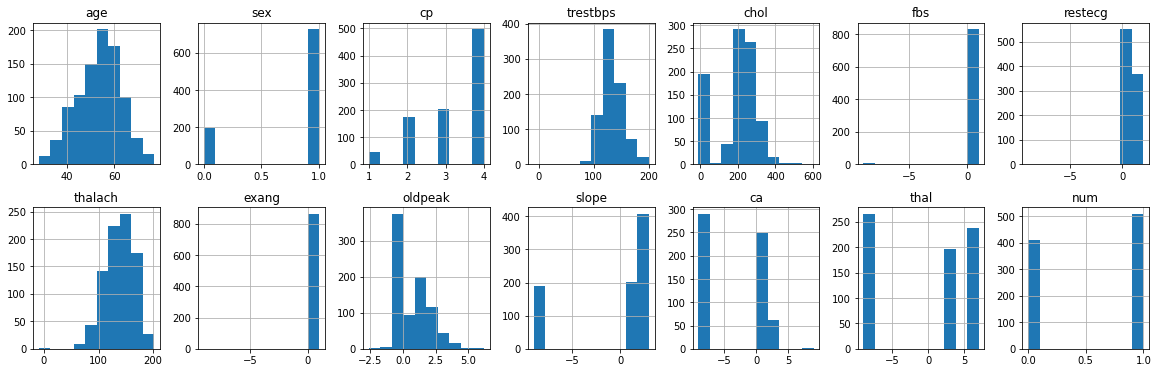

In [51]:
df.hist(figsize=(20, 6), layout=(2,7))
plt.show()

As we can see most fields are discrete only these ones are continuous: age, trestbps (resting blood pressure), chol (serum cholestoral), thalach (maximum heart rate achieved), and oldpeak (ST depression induced by exercise relative to rest).

Resting blood pressure, serum cholesterol and maximum heart rate achieved cannot be zero, otherwise the person is dead. So we will change every zero to np.nan.

In [52]:
remove_zeros = lambda x: x if x > 0 else np.nan

df.trestbps = df.trestbps.apply(remove_zeros)
df.chol = df.chol.apply(remove_zeros)
df.thalach = df.thalach.apply(remove_zeros)

### <font color="#ff8300">Boxplots and violinplots</font>

We may check for outliers using boxplots and for density estimation of the underlying distribution using violinplots. Data is normalized so the scale does not correspond to the actual values of data but it is enough to let us compare distributions.

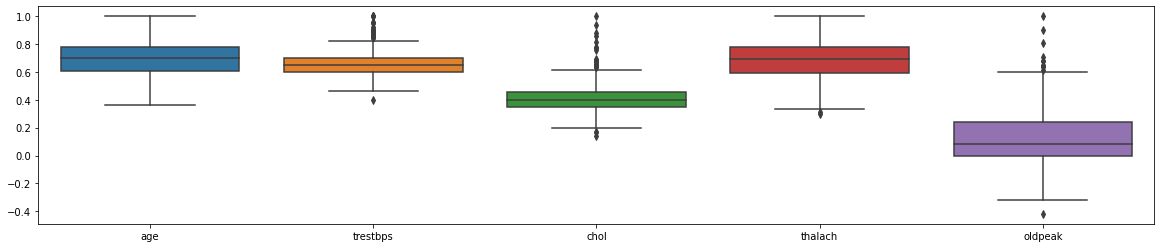

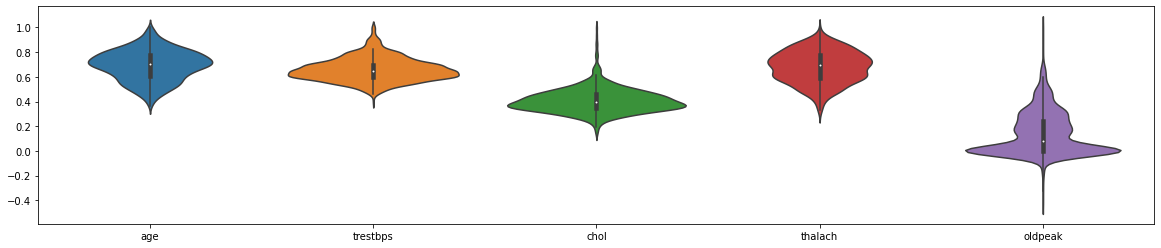

In [53]:
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_scl = abs_scaler(df[continuous_features])

fig, ax = plt.subplots(figsize=(20, 4))
g = sns.boxplot(
    data=df_scl
)
plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
g = sns.violinplot(
    data=df_scl
)
plt.show()

Some features present outliers. We will analyse if creating discrete features from these ones provide us with better data to predict the desired outcome.

### <font color="#ff8300">Heatmap</font>

Let's check correlation amongst the features. Features with high correlation may be removed or help us find an association with heart disease.

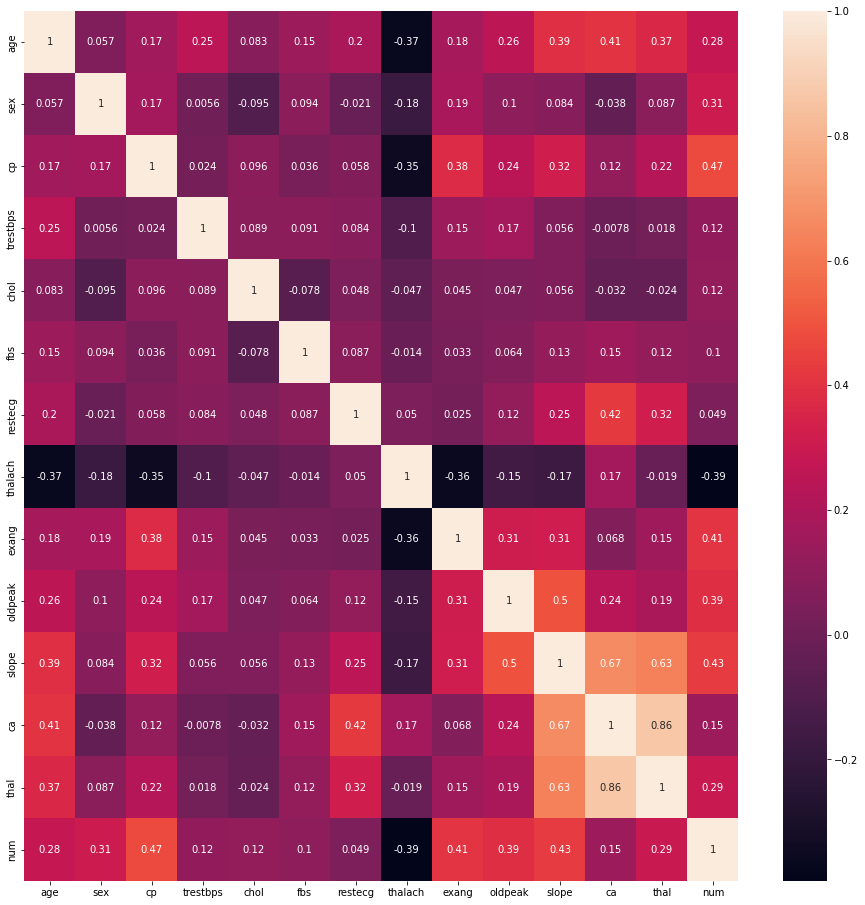

In [54]:
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(16, 16))
g = sns.heatmap(
    df_corr, annot=True
)
plt.show()

The features ca and thal are highly correlated. Unfortunetely, data description is not enough to let us know what they refer to. So we will keep them both.

### <font color="#ff8300">Data quantification</font>

I have developed the function quantify features that automatically analyse all the features and check which ones gives us a better insight if transformed from a continuous scale to a discrete one. We only need to inform which one is the target.

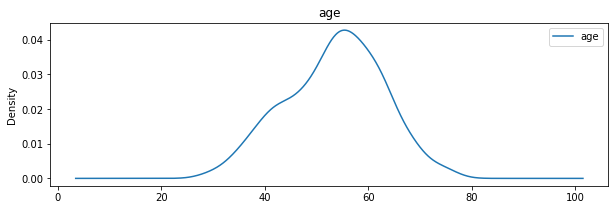

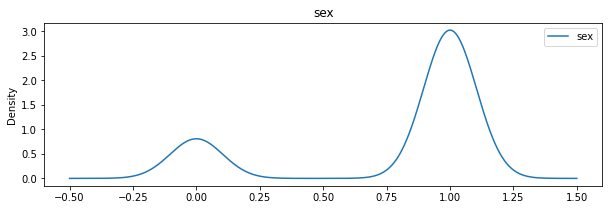

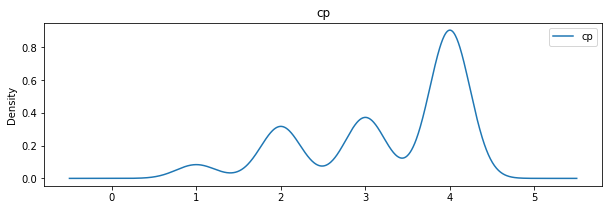

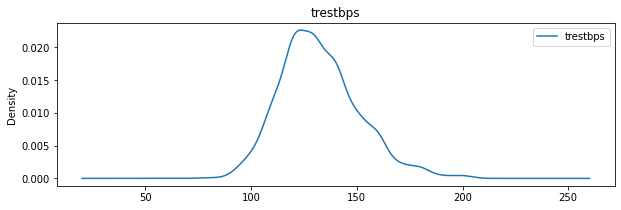

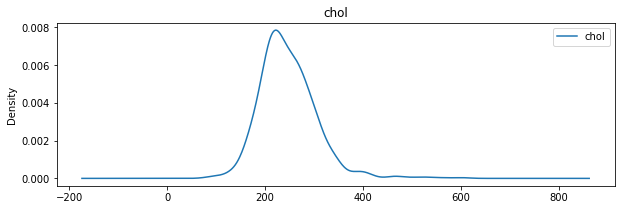

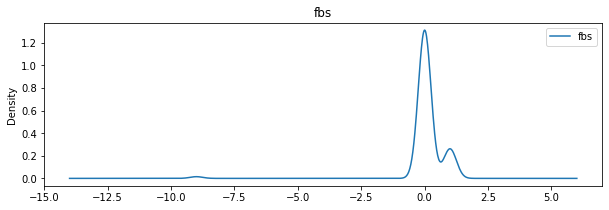

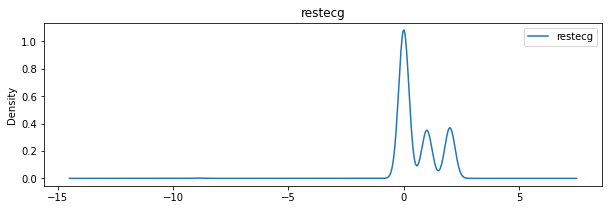

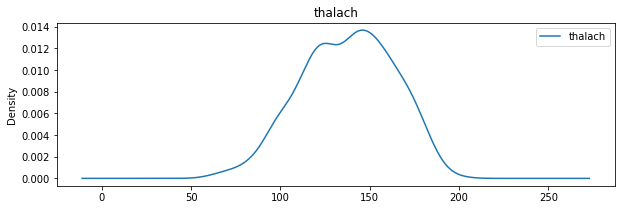

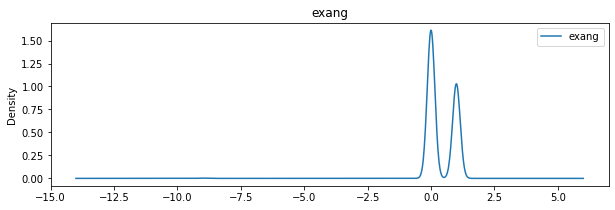

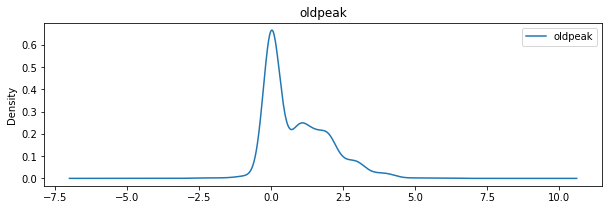

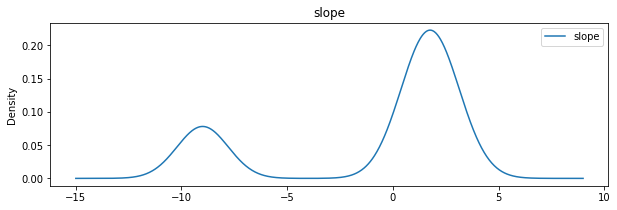

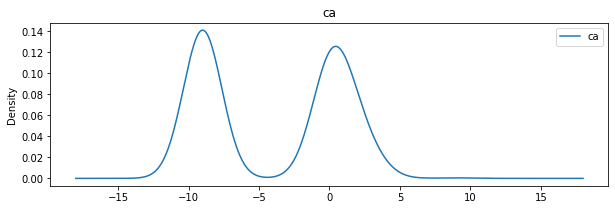

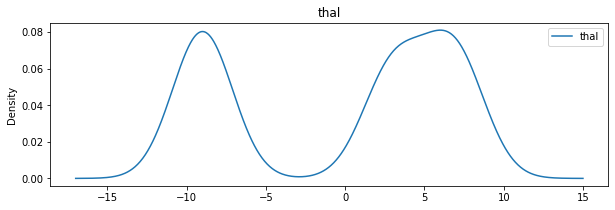

,Feature,N Parts,Equally
0,trestbps,5,False
1,chol,5,False
2,fbs,5,False
3,restecg,5,True
4,exang,5,True
5,oldpeak,5,False


Dropping trestbps_lbl
Dropping fbs_lbl
Dropping oldpeak_lbl


In [55]:
df = quantify_features(df, target='num')

The algorithm identified 6 features to quantify and decided to keep 3 of them. Probably because the other ones are highly correlated to the original ones.

In [56]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'chol_lbl',
       'restecg_lbl', 'exang_lbl'],
      dtype='object')

In [57]:
df.exang.unique()

array([ 0.,  1., nan, -9.])

In [58]:
df.restecg.unique()

array([ 2.,  0.,  1., nan, -9.])

The features exang and restecg are categorical so we will drop their quantization.

In [59]:
df.drop(columns=['restecg_lbl', 'exang_lbl'], inplace=True)

In [60]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,chol_lbl
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1


In [61]:
df.shape

(920, 15)

We've kept chol_lbl.

### <font color="#ff8300">Features selection</font>

In [62]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,chol_lbl
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1


Now we will remove features with poor (less then 20%) correlation to the target.

In [63]:
df_corr = df.corr()
arr = list(df_corr.loc['num'].items())
# Highest correlation first
arr.sort(key=lambda x: np.abs(x[1]), reverse=True)
columns = [x[0] for x in arr if np.abs(np.round(x[1], 2)) >= 0.2]
df = df[columns].copy()

In [64]:
df.head()

,num,cp,slope,exang,thalach,oldpeak,sex,thal,age,chol_lbl
0,0,1.0,3.0,0.0,150.0,2.3,1.0,6.0,63.0,1
1,1,4.0,2.0,1.0,108.0,1.5,1.0,3.0,67.0,1
2,1,4.0,2.0,1.0,129.0,2.6,1.0,7.0,67.0,1
3,0,3.0,3.0,0.0,187.0,3.5,1.0,3.0,37.0,1
4,0,2.0,1.0,0.0,172.0,1.4,0.0,3.0,41.0,1


Nothing changed. Good!

### <font color="#ff8300">Pairplots</font>

Finally we will analyse pairwise bivariate distributions to check if any two features helps us identify the presence of heart disease.

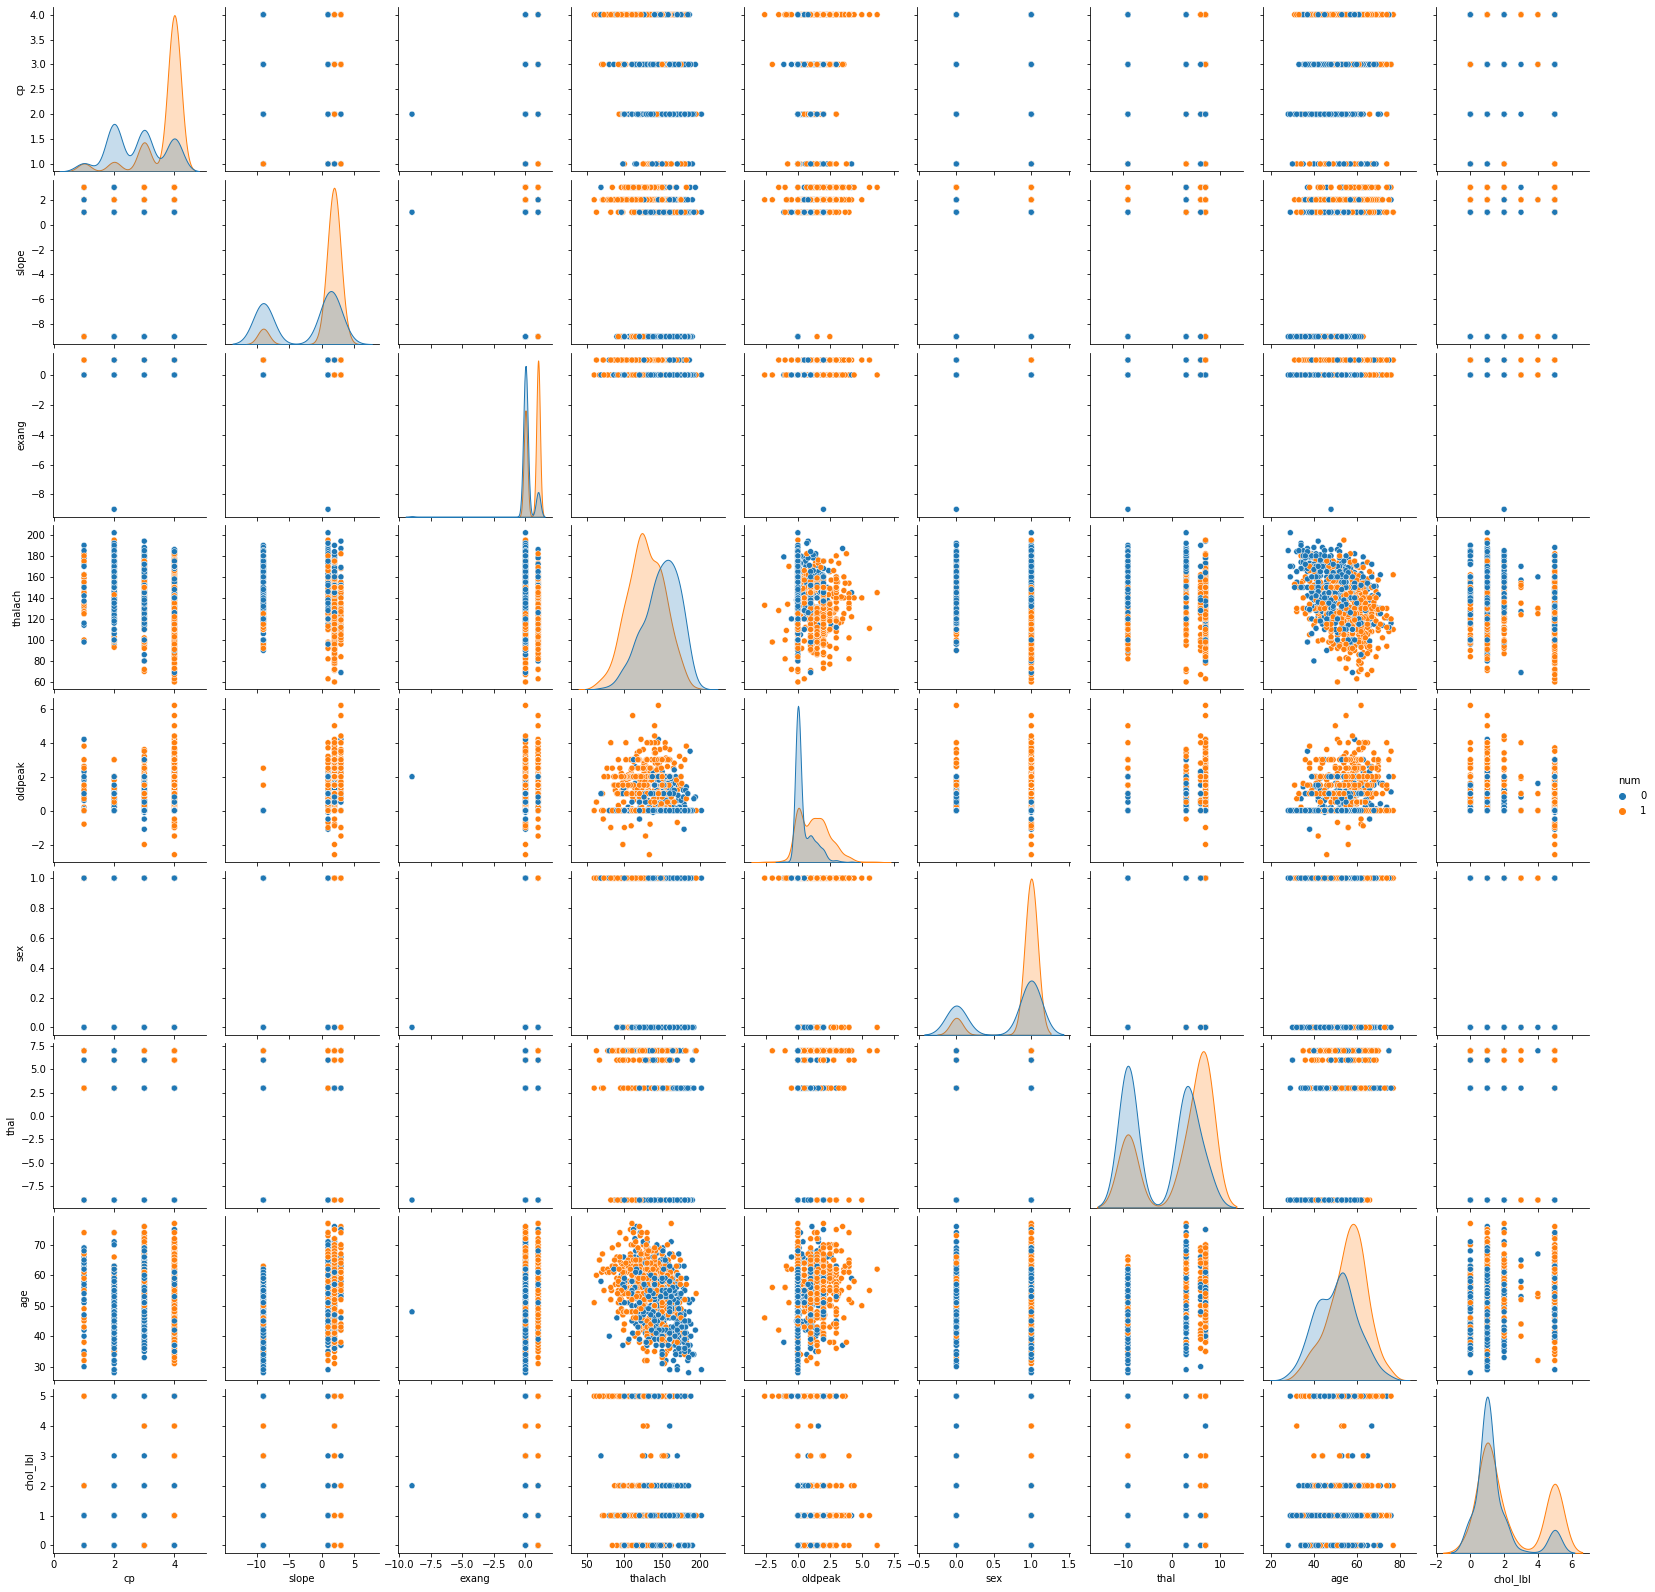

In [65]:
sns.pairplot(df, hue='num')

plt.show()

It seems that the model will have a hard time learning how to distinguish presence from absence of heart disease.

### <font color="#ff8300">Missing data</font>

We will use median to fill mising data. Probably not the best strategy in this case if we were dealing with real data, but we will do this for simplicity sake.

In [66]:
features_missing_values = [
    feature for (feature, count) in list(zip(
        df.isna().sum().index.values.tolist(),
        df.isna().sum().values.tolist()
    )) if count > 0
]

Let's plot the histograms to see how they will change.

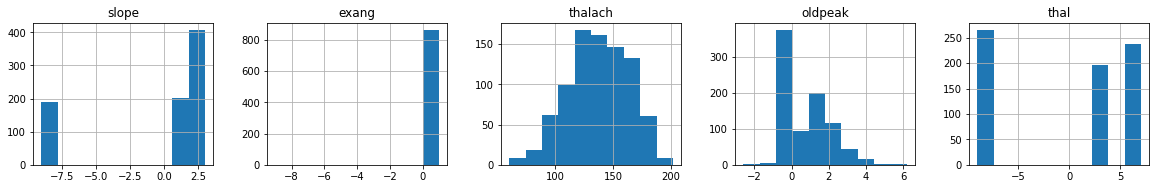

In [67]:
df[features_missing_values].hist(figsize=(20, 6), layout=(2,5));

In [68]:
for feature in features_missing_values:
    df.loc[df[feature].isna(), feature] = df[feature].median()

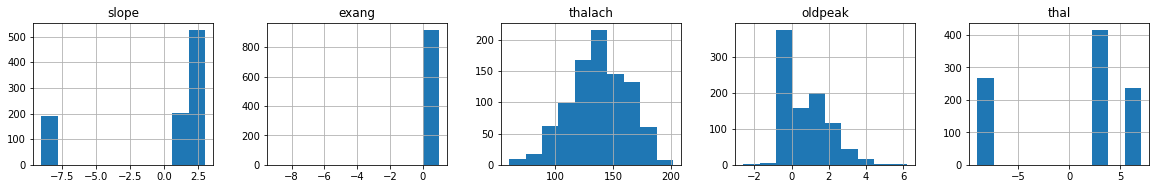

In [69]:
df[features_missing_values].hist(figsize=(20, 6), layout=(2,5));

The center of the graphics increased as expected.

### <font color="#ff8300">Train and eval split</font>

We will now split data into 3 sets: train and eval. The train set will be further split during training of the model.

In [70]:
eval = df.sample(frac=0.2, random_state=42).index

df_train = df.drop(index=eval)
df_eval = df.iloc[eval]

X_train, y_train = df_train.drop(
    labels='num', axis=1
).values, df_train['num'].values

X_eval, y_eval = df_eval.drop(
    labels='num', axis=1
).values, df_eval['num'].values

### <font color="#ff8300">Scaling</font>

StandardScaler will highlight outliers and MaxAbsScaler will constrain features within the same scale, preventing the algorithm to consider one feature above the others only because of the original scale.

In [71]:
scaler = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('MaxAbsScaler', MaxAbsScaler())
])

scaler.fit(X_train, y_train)

X_train_scaled = scaler.transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

## <font color="#5f093d">Modeling</font>

### <font color="#b21368">Model selection</font>

We will test 6 models and select the best one. Just then we will fine tune its parameters otherwise it could take a long time.

In [72]:
models = [
    ('KNeighborsClassifier', KNeighborsClassifier),
    ('LGBMClassifier', LGBMClassifier),
    ('MLPClassifier', MLPClassifier),
    ('SGDClassifier', SGDClassifier),
    ('SVC', SVC),
    ('XGBClassifier', XGBClassifier)
]

We will use 5 random sets from X_train.

In [73]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [74]:
result = []
scores = dict()

for name, model in tqdm(models):
    score = cross_val_score(
        model(),
        X_train_scaled,
        y_train,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1)
    scores[name] = score.tolist()
    result.append(np.abs(np.mean(score)))

100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


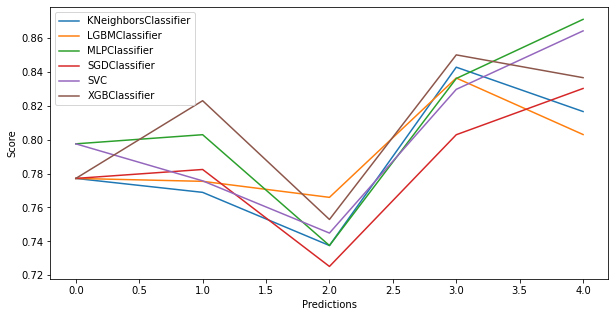

,KNeighborsClassifier,LGBMClassifier,MLPClassifier,SGDClassifier,SVC,XGBClassifier
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.788570,0.791563,0.808989,0.783555,0.802378,0.807899
std,0.041343,0.028553,0.049601,0.038709,0.046362,0.041195
min,0.737548,0.765954,0.737548,0.725208,0.744892,0.752912
25%,0.768900,0.775406,0.797520,0.777119,0.775698,0.777119
50%,0.777119,0.777119,0.802904,0.782394,0.797520,0.822948
75%,0.816565,0.802995,0.836048,0.802886,0.829647,0.836537
max,0.842717,0.836339,0.870928,0.830168,0.864135,0.849977


In [75]:
df_scores = pd.DataFrame(scores)

df_scores.plot(
    kind='line',
    figsize=(10,5),
    xlabel='Predictions',
    ylabel='Score',
    sort_columns=True
)
plt.show()

df_scores.describe()

From our tests, the chosen model is MLPClassifier.

### <font color="#b21368">Hyperparameters tuning</font>

The following sets of parameters will be used during training.

In [76]:
params = {
    'hidden_layer_sizes': [(100,), (100, 100,), (100, 100, 100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [1000],
    'tol': [1e-4, 1e-5],
    'early_stopping': [True, False],
    'n_iter_no_change': [10, 15],
}

Let's disable warnings. It's not a good practice but we will do it knowing we show treat these warnings not ignore them.

In [77]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [78]:
name, model = models[2]
rscv = RandomizedSearchCV(
    model(),
    params,
    scoring='f1_weighted',
    n_iter=15,
    cv=cv)
rscv.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=MLPClassifier(), n_iter=15,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'early_stopping': [True, False],
                                        'hidden_layer_sizes': [(100,),
                                                               (100, 100),
                                                               (100, 100, 100)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [1000],
                                        'n_iter_no_change': [10, 15],
                                        'solver': ['lbfgs', 'sgd', 'adam'],
                                        'tol': [0.0001, 1e-05]},
      

In [79]:
rscv.best_params_

{'activation': 'tanh',
 'early_stopping': False,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'max_iter': 1000,
 'n_iter_no_change': 15,
 'solver': 'adam',
 'tol': 0.0001}

Now let's train the model with the best parameters.

In [80]:
score = cross_val_score(
    model(**rscv.best_params_),
    X_train_scaled,
    y_train,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1)

scores[f'{name}_tuned'] = score.tolist()

And add the results and compare with the other models.

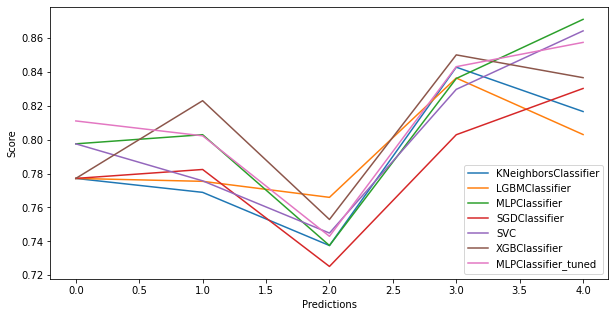

,KNeighborsClassifier,LGBMClassifier,MLPClassifier,SGDClassifier,SVC,XGBClassifier,MLPClassifier_tuned
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.788570,0.791563,0.808989,0.783555,0.802378,0.807899,0.811323
std,0.041343,0.028553,0.049601,0.038709,0.046362,0.041195,0.044372
min,0.737548,0.765954,0.737548,0.725208,0.744892,0.752912,0.742985
25%,0.768900,0.775406,0.797520,0.777119,0.775698,0.777119,0.802246
50%,0.777119,0.777119,0.802904,0.782394,0.797520,0.822948,0.811018
75%,0.816565,0.802995,0.836048,0.802886,0.829647,0.836537,0.843026
max,0.842717,0.836339,0.870928,0.830168,0.864135,0.849977,0.857342


In [81]:
df_scores = pd.DataFrame(scores)

df_scores.plot(
    kind='line',
    figsize=(10,5),
    xlabel='Predictions',
    ylabel='Score',
    sort_columns=True
)
plt.show()

df_scores.describe()

The model fine tuned is a little bit better than with default parameters.

## Evaluation

Median = 0.7879994827363248 Stddev = 0.09169679398668663


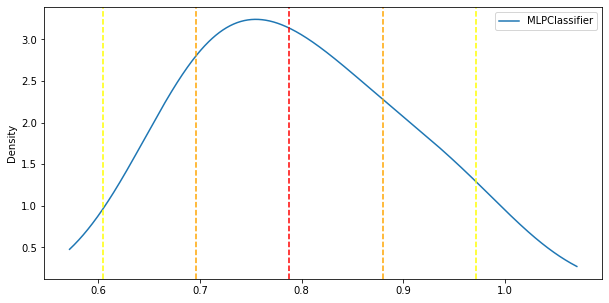

In [82]:
_ = eval_model(model(**rscv.best_params_), X_eval_scaled, y_eval, cv, 'f1_weighted')

As shown above, the model produced a result very similar to training results. So we can conclude that it generalized well enough.

With its result around 80%, there's enough room for improvement.